## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

Multioutput regression.

Motifications with respect to regression with 1-dimensional output:

Targets: 34-dimensional ratings of [speaker characteristics](https://github.com/laufergall/Subjective_Speaker_Characteristics) given to the 300 speakers of the [NSC](http://www.qu.tu-berlin.de/?id=nsc-corpus) corpus.

In [1]:
import io
import requests

import numpy as np
import pandas as pd

from reg_tuning import * # my helper functions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Load features and labels

In [5]:
path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

## 34items: Model tuning

Use the train data to find the regressor and its hyperparameters leading to the best performance. 

Not performing feature selection with "SelectKBest": Univariate feature selection does not support multilabel. 

In [4]:
# Standardize speech features  

dropcolumns = ['name','spkID','speaker_gender'] + items_names + traits_names

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_ratings_scores_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_ratings_scores_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_ratings_scores_test.drop(dropcolumns, axis=1)) 

In [5]:
# training data. Features and labels
X = feats_s_train # (2700, 88)
y = feats_ratings_scores_train[items_names].as_matrix() # (2700, 34)

# test data. Features and labels
Xt = feats_s_test # (891, 88)
yt = feats_ratings_scores_test[items_names].as_matrix() # (891, 34)

# split train data into 80% and 20% subsets - with balance in trait and gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, 
                                  test_size=0.20, 
                                  stratify = feats_ratings_scores_train['speaker_gender'], 
                                  random_state=2302)

In [10]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned models trained on training data, to be appended
trained_all = []

In [7]:
# save splits

label = 'multioutput_34items'

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X_' + label + '.npy', X)
np.save(r'.\data_while_tuning\y_' + label + '.npy', y)
np.save(r'.\data_while_tuning\Xt_' + label + '.npy', Xt)
np.save(r'.\data_while_tuning\yt_' + label + '.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX_' + label + '.npy', AX)
np.save(r'.\data_while_tuning\BX_' + label + '.npy', BX)
np.save(r'.\data_while_tuning\Ay_' + label + '.npy', Ay)
np.save(r'.\data_while_tuning\By_' + label + '.npy', By)

### Calling hp_tuner() for each regressor

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [3]:
label = 'multioutput_34items'

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X_' + label + '.npy')
y = np.load(r'.\data_while_tuning\y_' + label + '.npy')
Xt = np.load(r'.\data_while_tuning\Xt_' + label + '.npy')
yt = np.load(r'.\data_while_tuning\yt_' + label + '.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX_' + label + '.npy')
BX = np.load(r'.\data_while_tuning\BX_' + label + '.npy')
Ay = np.load(r'.\data_while_tuning\Ay_' + label + '.npy')
By = np.load(r'.\data_while_tuning\By_' + label + '.npy')


In [9]:
# # Loading outpus of hp tuning from disk
# tuning_all, trained_all = load_tuning(label)

Call this after each experiment **to recover later**: 

In [10]:
# # save tuning_all (.csv) and trained_all (namemodel.sav)
# save_tuning(tuning_all, trained_all, label)

#### Random Forest

*class sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)*

Tune: max_features, max_depth, min_samples_leaf

In [6]:
from sklearn.ensemble import RandomForestRegressor

"""
Random Forest
"""
def get_RandomForestRegressor2tune():
    
    model = RandomForestRegressor(random_state=2302, max_features = None)
    hp = dict(
        regressor__estimator__max_features = np.arange(2,50),
        regressor__estimator__max_depth = np.arange(2,50), 
        regressor__estimator__min_samples_leaf = np.arange(2,50) 
    )
    return 'RandomForestRegressor', model, hp

# tune this model (multiputput)
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_RandomForestRegressor2tune], 
                           label,
                           feats_names,
                           [88], # feature selection not performed
                           mode='random',
                           n_iter=50
                          )

'RandomForestRegressor' -> Best cross-val score on A set: -49.782665 using {'regressor__estimator__min_samples_leaf': 2, 'regressor__estimator__max_features': 40, 'regressor__estimator__max_depth': 22}
'RandomForestRegressor' -> root mean_squared_error on B set: 6.850574



In [7]:
from sklearn.ensemble import RandomForestRegressor

"""
Random Forest
"""
def get_RandomForestRegressor2tune():
    
    model = RandomForestRegressor(random_state=2302, max_features = None)
    hp = dict(
        regressor__estimator__max_features = np.arange(30,50),
        regressor__estimator__max_depth = np.arange(15,35), 
        regressor__estimator__min_samples_leaf = np.arange(2,5) 
    )
    return 'RandomForestRegressor', model, hp

# tune this model (multiputput)
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_RandomForestRegressor2tune], 
                           label,
                           feats_names,
                           [88], # feature selection not performed
                           mode='random',
                           n_iter=50
                          )

'RandomForestRegressor' -> Best cross-val score on A set: -49.731643 using {'regressor__estimator__min_samples_leaf': 3, 'regressor__estimator__max_features': 40, 'regressor__estimator__max_depth': 34}
'RandomForestRegressor' -> root mean_squared_error on B set: 6.886105



In [12]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, label)

###  (Error) Multilayer Perceptron for regression

TODO: Solve error: related to the shape of the target vector.

Defining model architecture: Multilayer Perceptron (MLP) using keras with TensorFlow backend.

* input the (standardized) speech features (input_dim = 88)
* one fully-connected hidden layer with the same number of neurons as input speech features
* output with linear activation function (for regession) with the same number of neurons as output speaker characteristics

Tuning hyperparameters using StratifiedKFold cross-validation with set A:

* number of epochs
* batch size
* number of hidden units
* optimizer
* learning rate
* activation function hidden layer
* dropout regularization

Evaluating performance on the hold-out set B.

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

"""
MLP with KerasRegressor
"""

def create_model(optimizer = 'Adam', learn_rate=0.2, neurons=1, activation='relu', dropout_rate=0.0):

    model = Sequential()

    model.add(Dense(neurons,
                    activation=activation, 
                    input_dim=88))
    model.add(Dropout(dropout_rate))
    model.add(Dense(34))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

In [14]:
# 1st round (tuning epochs, batch_size, neurons, learn rate):
    
def get_KerasRegressor2tune():
    
    model = KerasRegressor(build_fn = create_model, verbose=0)
                        
    hp = dict(
        regressor__estimator__epochs = [25,50,75,100],
        regressor__estimator__batch_size = [5,10], 
        regressor__estimator__neurons = [40, 60, 80, 160],
        regressor__estimator__learn_rate = np.arange(start=0.2, stop=1.0, step=0.05) 
        #regressor__estimator__activation = ['relu'], # ['softmax', 'softplus', 'sofsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
        #regressor__estimator__dropout_rate = [0.5], # np.arange(start=0, stop=1, step=0.1)
        #regressor__estimator__optimizer = ['Adam'] #['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    )
    return 'KerasRegressor', model, hp

tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_KerasRegressor2tune], 
                           label,
                           feats_names,
                           [88], # no feature selection
                           'random',
                           n_iter=20
                          )


C:\Users\Laura\Anaconda3\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


ValueError: Error when checking target: expected dense_4 to have shape (34,) but got array with shape (1,)

In [ ]:
# # 2nd round (tuning activation and dropout_rate):
    
# def get_KerasRegressor2tune():
    
#     model = KerasRegressor(build_fn = create_model, verbose=0)
                        
#     hp = dict(
#         regressor__estimator__epochs = [75], #[25,50,75,100],
#         regressor__estimator__batch_size = [5], # [5,10], 
#         regressor__estimator__neurons = [160], #[40, 80, 160],
#         regressor__estimator__learn_rate = [0.8], # np.arange(start=0.2, stop=1.0, step=0.05) 
#         regressor__estimator__activation = ['relu','tanh','sigmoid','linear'], # ['softmax', 'softplus', 'sofsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#         regressor__estimator__dropout_rate = np.arange(start=0, stop=1, step=0.2)
#         #regressor__estimator__optimizer = ['Adam'] #['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#     )
#     return 'KerasRegressor', model, hp


# tuning, trained = hp_tuner(AX, BX, Ay, By, 
#                            [get_KerasRegressor2tune], 
#                            label,
#                            feats_names,
#                            [88], # no feature selection
#                            'grid'
#                           )


#### Decision tree

*class sklearn.tree.DecisionTreeRegressor(criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort=False)*

Tune: max_depth

In [15]:
from sklearn.tree import DecisionTreeRegressor

"""
Decision Trees
"""
def get_DecisionTreeRegressor2tune():
    
    model = DecisionTreeRegressor()
    hp = dict(
        regressor__estimator__max_depth = np.arange(2,20), 
        regressor__estimator__max_features = np.arange(2,50)
    )
    return 'DecisionTreeRegressor', model, hp

# tune this model (multiputput)
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_DecisionTreeRegressor2tune], 
                           label,
                           feats_names,
                           [88], # feature selection not performed
                           mode='random',
                           n_iter=30
                          )

'DecisionTreeRegressor' -> Best cross-val score on A set: -70.723342 using {'regressor__estimator__max_features': 42, 'regressor__estimator__max_depth': 5}
'DecisionTreeRegressor' -> root mean_squared_error on B set: 8.227232



In [16]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, label)

Add baseline performance.

In [17]:
from sklearn.dummy import DummyRegressor

model = DummyRegressor(strategy='mean')
model.fit(AX, Ay)
By_pred = model.predict(BX)
score_on_B = np.sqrt(mean_squared_error(By, By_pred))
d = {
    'regressors_names': ['DummyRegressor'],
    'best_accs': score_on_B,
    'best_hps': '',
    'sel_feats': '',
    'sel_feats_i': ''
    }

tuning = pd.DataFrame(data = d)
trained = model.fit(X, y)

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append([trained])

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, label)

## Testing

### RMSE
Testing the best model found after hyperparameter tuning.

Performance metric: RMSE.
    
The predictions correspond to the scores of each test segment (3 parts x 4 dialogs) spoken by the same test speaker. I perform the average of the predicted scores that correspond to the same speaker - to be compared to the true scores.

Visualization: pairplot of scores of true and predicted test data, grouped-averaged by speakers.

Load data if new ipynb session:

In [3]:
label = 'multioutput_34items'


path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X_' + label + '.npy')
y = np.load(r'.\data_while_tuning\y_' + label + '.npy')
Xt = np.load(r'.\data_while_tuning\Xt_' + label + '.npy')
yt = np.load(r'.\data_while_tuning\yt_' + label + '.npy')

# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning(label)
tuning_all

,best_accs,best_hps,regressors_names,sel_feats,sel_feats_i
0,6.886105,"{'regressor__estimator__min_samples_leaf': 3, ...",RandomForestRegressor,"['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semit...",[ True True True True True True True Tr...
1,6.886105,"{'regressor__estimator__min_samples_leaf': 3, ...",RandomForestRegressor,"['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semit...",[ True True True True True True True Tr...
2,8.227232,"{'regressor__estimator__max_features': 42, 're...",DecisionTreeRegressor,"['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semit...",[ True True True True True True True Tr...
3,10.356033,NaN,DummyRegressor,NaN,NaN


In [4]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmin()

print('Selected classifier based on the best performance on B: %r (perf. on B = %0.2f)' % (tuning_all.loc[i_best,'regressors_names'], round(best_accs[i_best],2)))

Selected classifier based on the best performance on B: 'RandomForestRegressor' (perf. on B = 6.89)


In [12]:
from sklearn.metrics import r2_score

# go through performace for all regressors

# removing duplicates from tuning_all (same classifier tuned twice with different searchers)
indexes = tuning_all['regressors_names'].drop_duplicates(keep='last').index.values

# dataframe for summary of performances
# performances = pd.DataFrame(tuning_all.loc[indexes,['regressors_names','best_accs']])

for i in indexes:

    # compute predictions with the best tuned regressor

    yt_pred = trained_all[i][0].predict(Xt)

    # average of outputs that belong to the same speaker

    true_scores = pd.DataFrame(data = feats_ratings_scores_test[items_names+['spkID']])
    true_scores['type']='true'

    pred_scores=pd.DataFrame()
    for t in np.arange(0,len(items_names)):
        pred_scores[items_names[t]] = yt_pred[:, t] 
    pred_scores['spkID'] = feats_ratings_scores_test['spkID']


    # group by speakers and average
    true_scores_avg = true_scores.groupby('spkID').mean()

    pred_scores_avg = pred_scores.groupby('spkID').mean()


    # RMSE and R2 for each trait separately
    for t in np.arange(0,len(items_names)):
        print('%r -> avg RMSE %r = %.2f' % (tuning_all.loc[i,'regressors_names'],
                                      items_names[t], 
                                      np.sqrt(mean_squared_error(true_scores_avg[items_names[t]].as_matrix(), 
                                                                                  pred_scores_avg[items_names[t]].as_matrix()))
                                     )
             )
        
        print('%r -> avg R2 %r = %.2f' % (tuning_all.loc[i,'regressors_names'],
                                      items_names[t], 
                                      r2_score(true_scores_avg[items_names[t]].as_matrix(), 
                                                                                  pred_scores_avg[items_names[t]].as_matrix())
                                     )
             )

    # overall RMSE and R2
    myrmse_avg = np.sqrt(mean_squared_error(true_scores_avg[items_names].as_matrix(), 
                                            pred_scores_avg[items_names].as_matrix())
                        )
    myr2_avg = r2_score(true_scores_avg[items_names].as_matrix(), 
                                            pred_scores_avg[items_names].as_matrix()
                        )
    print('%r -> avg R2 overall: %0.2f' % (tuning_all.loc[i,'regressors_names'], myr2_avg))
    print('')
    
        
    # append true and predicted scores

    true_scores_avg.reset_index(inplace=True)
    pred_scores_avg.reset_index(inplace=True) 

    true_scores_avg['type']='true'
    pred_scores_avg['type']='pred'

    test_scores_avg=true_scores_avg.append(pred_scores_avg)

#     # pairplot color-coded by true/predicted test data
#     myfig = sns.pairplot(test_scores_avg.drop('spkID', axis=1), hue='type')

#     # save figure
#     filename = label + '_test_'+tuning_all.loc[i,'regressors_names']+'.png'
#     myfig.savefig('.\\figures\\' + filename, bbox_inches = 'tight')  


'RandomForestRegressor' -> avg RMSE 'non_likable' = 10.01
'RandomForestRegressor' -> avg R2 'non_likable' = 0.12
'RandomForestRegressor' -> avg RMSE 'secure' = 10.65
'RandomForestRegressor' -> avg R2 'secure' = 0.11
'RandomForestRegressor' -> avg RMSE 'attractive' = 9.12
'RandomForestRegressor' -> avg R2 'attractive' = 0.17
'RandomForestRegressor' -> avg RMSE 'unsympathetic' = 7.06
'RandomForestRegressor' -> avg R2 'unsympathetic' = 0.17
'RandomForestRegressor' -> avg RMSE 'indecisive' = 9.55
'RandomForestRegressor' -> avg R2 'indecisive' = 0.04
'RandomForestRegressor' -> avg RMSE 'unobtrusive' = 8.75
'RandomForestRegressor' -> avg R2 'unobtrusive' = -0.09
'RandomForestRegressor' -> avg RMSE 'distant' = 9.17
'RandomForestRegressor' -> avg R2 'distant' = 0.17
'RandomForestRegressor' -> avg RMSE 'bored' = 8.82
'RandomForestRegressor' -> avg R2 'bored' = 0.37
'RandomForestRegressor' -> avg RMSE 'emotional' = 8.10
'RandomForestRegressor' -> avg R2 'emotional' = 0.36
'RandomForestRegressor'

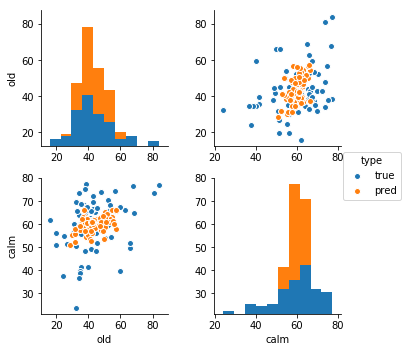

In [9]:
# example predictions made by RandomForestRegressor

sns.pairplot(test_scores_avg[['type','old','calm']], hue='type')

Animation (.html) of pairs of true-predicted WAAT scores. For each frame i, 2 points are plotted in 2D: one corresponding to the true WAAT of speaker i and the other one corresponding to the averaged predicted WAAT of the same speaker.

TODO: Select test_scores_avg corresponding to the regressor to test.

In [ ]:
# from matplotlib.animation import FuncAnimation

# unique_speakers = test_scores_avg['spkID'].unique()

# fig, ax = plt.subplots()

# # Plot a scatter that persists(isn't redrawn) 
# ax.set_xlabel('warmth')
# ax.set_ylabel('attractiveness')
# ax.set_xlim(-6, 4)  
# ax.set_ylim(-3, 2)        

# def update(i):
#     spk=unique_speakers[i]
#     coor_x = test_scores_avg.loc[test_scores_avg['spkID']==spk, traits_names[0]]
#     coor_y = test_scores_avg.loc[test_scores_avg['spkID']==spk, traits_names[1]]
#     ax.scatter(coor_x, coor_y)
#     ax.plot(coor_x, coor_y) 
#     return ax

# # create animation
# anim = FuncAnimation(fig, update, frames=np.arange(0, len(unique_speakers)), interval=200, save_count=200)

# # save animation
# filename = r'\multioutput_test_'+tuning_all.loc[i,'regressors_names']+'.html'
# anim.save(r'.\figures' + filename, dpi=80, writer='imagemagick')
